In [22]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

In [4]:
var_t = pm.Uniform('test',0,4)
print var_t.random()

3.92440210131


## Data Structure

In [248]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+grader.bias_mean,self.precision+grader.bias_tau)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_handins):
        # Distribute handins
        for i in xrange(0,n_handins):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

## Generate Observed Data

In [249]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,60):
    g = grader('grader_%i' % i,B_mu.random(),B_tau.random())
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, g, t_mu, T_tau.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins(5)

In [61]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(60,120):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(10)

In [62]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(40,60):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(10)

## Models

In [231]:
def execute_model(model,data,samples,burn):
    mcmc = pm.MCMC(model(data))
    mcmc.sample(samples,burn)
    return mcmc

In [218]:
def handin_model_Oles(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    T = dict()
    B_mu = dict()
    B = dict()
    B_tau = dict()
    O = list()
    
    e = pm.Gamma('error',10,0.1)
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), T_mu[h_id], T_tau[h_id])        
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), B_mu[g_id], B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=e, observed=True, value=val))
                               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(T),
                  pm.Container(B_mu),
                  pm.Container(B_tau),
                  pm.Container(B),
                  pm.Container(O),
                  e]
    
    model = pm.Model(collection)
    return model


In [10]:
def peergrade_model(data):
    N_H = len(data)
    
    # Bias
    T_tau = dict()
    T_mu = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
            if g_id not in B_tau:
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T_mu[h_id] + B_mu[g_id], tau=T_tau[h_id] + B_tau[g_id], observed=True, value=val))
               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau),
                  pm.Container(O)]
    
    model = pm.Model(collection)
#    map_ = pm.MAP(model)
#    map_.fit()
    return model


In [245]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_ole = execute_model(handin_model_Oles,values,11000,1000)

 [                  2%                  ] 245 of 11000 complete in 13.4 secHalting at iteration  253  of  11000


In [250]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_peergrade = execute_model(peergrade_model,values,11000,1000)

 [-----------------100%-----------------] 11000 of 11000 complete in 570.3 sec

## Plot

In [290]:
def plot_traces_bias(assignment,mcmc):
    figsize(12.5, 4)
    bias_abs = list()
    for i, g in enumerate(assignment.graders.keys()):
        
        plt.subplot(2,1,1) 
        
        b_mu = mcmc.trace('B_mu_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $p_{\mu_b}$')
        
        leg = plt.legend(loc=1)
#        leg.get_frame().set_alpha(0.4)
        
        plt.subplot(2,1,2) 
        
        b_tau = mcmc.trace('B_tau_%s' % str(g))[:]
        plt.plot(b_tau,color="#467821",label=r'posterior $p_{\tau_b}$')

        leg = plt.legend(loc=1)
#        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        return None

In [291]:
def plot_traces_handin(assignment,mcmc):
    figsize(12.5, 4)
    for i, g in enumerate(assignment.handins.keys()):
        
        plt.subplot(2,1,1) 
        
        b_mu = mcmc.trace('T_mu_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $p_{\mu_h}$')
        #plt.title("Grading score for %s" % g)
        leg = plt.legend(loc=4)
#        leg.get_frame().set_alpha(0.4)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.subplot(2,1,2) 

        b_tau = mcmc.trace('T_tau_%s' % str(g))[:]
        plt.plot(b_tau,color="#467821",label=r'posterior $p_{\tau_h}$')
#        plt.title("Grading score for handin %s" % g)
#        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        leg = plt.legend(loc=1)
#        leg.get_frame().set_alpha(0.4)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        return None

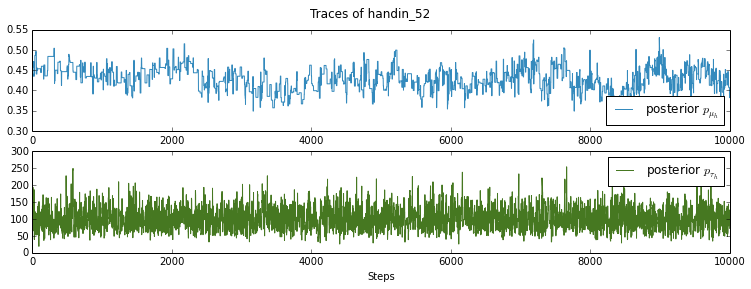

ValueError: max() arg is an empty sequence

In [292]:
plot_traces_handin(assignment_data_true,mcmc_peergrade)

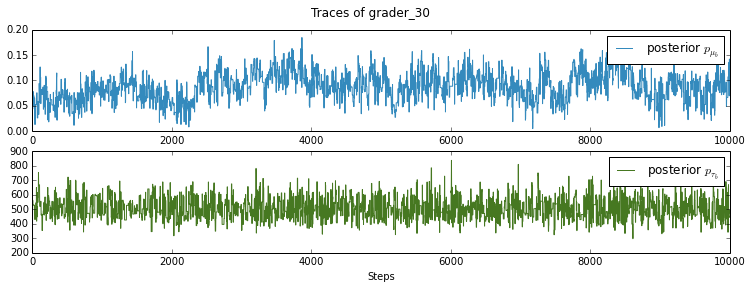

ValueError: max() arg is an empty sequence

In [293]:
plot_traces_bias(assignment_data_true,mcmc_peergrade)

In [235]:
from scipy.stats import norm

In [298]:
def plot_dist(assignment,mcmc):
    figsize(12.5, 6)

    for i, g in enumerate(assignment.handins.keys()):

        plt.subplot(2,1,1) 
        x = np.linspace(0,1,1000)    
        h_mean = np.mean(mcmc.trace('T_mu_%s' % str(g))[:])
        h_std = np.sqrt(1.0 / np.mean(mcmc.trace('T_tau_%s' % str(g))[:]))
        print h_mean, h_std
        y = norm.pdf(x, loc=h_mean, scale=h_std)
        plt.plot(x,y,color="#348ABD",label=r'posterior distriubtion of $p_{T_h}$')
        plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        plt.vlines(h_mean, 0, 3, linestyle="--", linewidth=2, label=r'Expected value of $p_{T_h}$')
        plt.title(r'Prior distribution of $T_h$ where $h$ is %s' % g, fontsize=12)
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        break
        
    for i, g in enumerate(assignment.graders.keys()):
        
        plt.subplot(2,1,2) 
        x = np.linspace(-0.2,0.2,1000)            
        b_mean = np.mean(mcmc.trace('B_mu_%s' % str(g))[:])
        b_std = np.sqrt(1.0 / np.mean(mcmc.trace('B_tau_%s' % str(g))[:]))
        y = norm.pdf(x, loc=b_mean, scale=b_std)
        plt.plot(x,y,color="#467821",label=r'posterior distriubtion of $p_{B_g}$')
        plt.fill_between(x, 0, y, color="#467821", alpha=0.4)
        plt.vlines(b_mean, 0, 8, linestyle="--", linewidth=2, label=r'Expected value of $p_{B_g}$')
        plt.title(r'Prior distribution of $B_g$ where $g$ is %s' % g, fontsize=12)
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.4)
        plt.ylim(0,8)
        plt.xlim(-0.2,0.2)
        break


#        leg.get_frame().set_alpha(0.4)
#    plt.suptitle("Posterior distributions of a handin score and bias")
    plt.show()
    plt.tight_layout()

0.429195222289 0.0991053475484


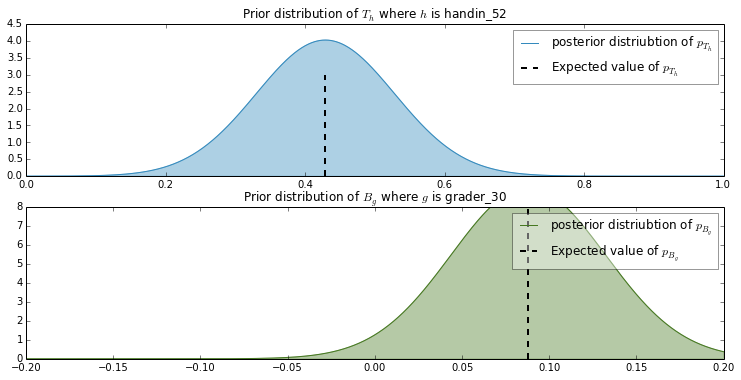

ValueError: max() arg is an empty sequence

In [299]:
plot_dist(assignment_data_true,mcmc_peergrade)

In [ ]:
ax = plt.subplot(1,1,1) 
        
e = mcmc_ole[0].trace('error')[:]
print np.mean(e)
plt.plot(e,color="#348ABD",label="Bias mu")
plt.title("error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height])

plt.show()

In [238]:
def plot_traces_handin(assignment,mcmc):
    bias_abs = list()
    for i, g in enumerate(assignment.handins.keys()):
        
        ax = plt.subplot(len(assignment.handins.keys()),1,i+1) 
        
        b_mu = mcmc.trace('T_mu_%s' % str(g))[:]
        b_tau = mcmc.trace('T_tau_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label="Handin mu")
#        plt.plot(b_tau,color="#A60628",label="Handin tau")
        plt.title("grading for handin %s" % g)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        box = ax.get_position()
        ax.set_position([box.x0, box.y0,
                         box.width*1.5, box.height*5])

        plt.show()
        return none

In [240]:
def find_bias(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('B_tau_%s' % str(g))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('B_mu_%s' % str(g))[:])
        bias.append((value,g))
    return bias

In [241]:
def find_T(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('T_tau_%s' % str(h))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('T_mu_%s' % str(h))[:])
        T.append((value,h))
    return T

In [313]:
def compare_to_generated(assignment_data,mcmc_handins,find,func='mean'):
    figsize(7,10)
    bias_abs_1 = find(assignment_data, mcmc_handins[0], func)
#    bias_abs_2 = find(assignment_data, mcmc_handins[1], func)
#    bias_abs_3 = find(assignment_data, mcmc_handins[2], func)

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
#    collected = list()
    collected = bias_abs_1[:]
#    collected.extend(bias_abs_2[:])
#    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = list()
    if find.func_name == "find_bias":
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.bias_mean))
            else:
                sorted_list.append((_id,g.bias_tau))
    else:
        for _id, h in assignment_data.handins.iteritems():
            if func == "mean":
                sorted_list.append((_id,h.true_val))
            else:
                sorted_list.append((_id,h.precision))
            
    sorted_list.sort(key=lambda x: x[1])

    ax = plt.subplot(111)
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if find.func_name != "find_bias" and func == "mean":
            mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
            mean_score_values.append(mean_score)
        
        MS_val.append(np.mean(compared[_id]))
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
    print MSE_M
    if find.func_name != "find_bias" and func == "mean":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
        print MSE_T
    box_text = ""
    if find.func_name != "find_bias" and func == "mean":
        box_text = 'MSE model: %(h)f\nMSE graded: %(g)f' % {'h': MSE_M, 'g':MSE_T}
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: x,y)
    if find.func_name == "find_bias":
        plt.plot(score_values,y_,'o',color="#467821",label="Pymc found bias",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',color="#A60628",label="True bias",alpha=0.6,linewidth=0)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'o',color="#A60628",label="Mean of observed graded scores",alpha=0.6)
        plt.plot(score_values,y,'o',color='#348ABD',label="Pymc found handin score",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',label="True handin score",alpha=0.6,linewidth=0)
    plt.yticks(xrange(0,len(sorted_list)),labels)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    if find.func_name == "find_bias":
        if func == "mean":
            plt.xlabel(r"True graders bias mean compared to the found bias mean through pymc")
        else:
            plt.xlabel(r"True graders bias precision ($\tau$) compared to the found bias precision ($\tau$) through pymc")
        plt.ylabel("Graders")
    else:
        plt.xlabel("True handin score compared to the found handin score through pymc")
        plt.ylabel("Handins")
    plt.show()
    plt.tight_layout()

### Peergrad_model

0.000866611979262
0.00167467296616


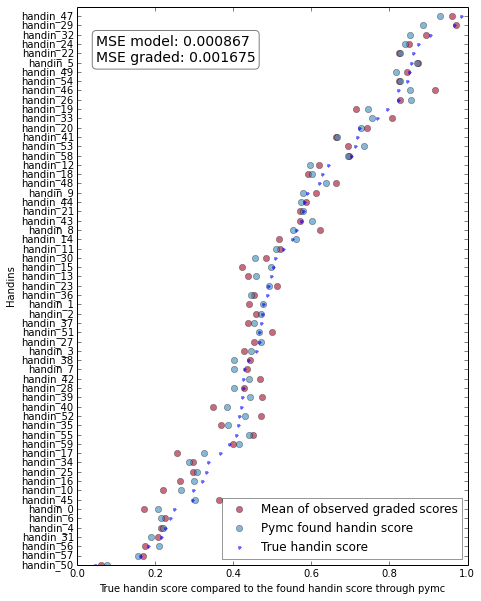

ValueError: max() arg is an empty sequence

In [314]:
compare_to_generated(assignment_data_true,[mcmc_peergrade]*3,find_T,'mean')

0.00110323635368


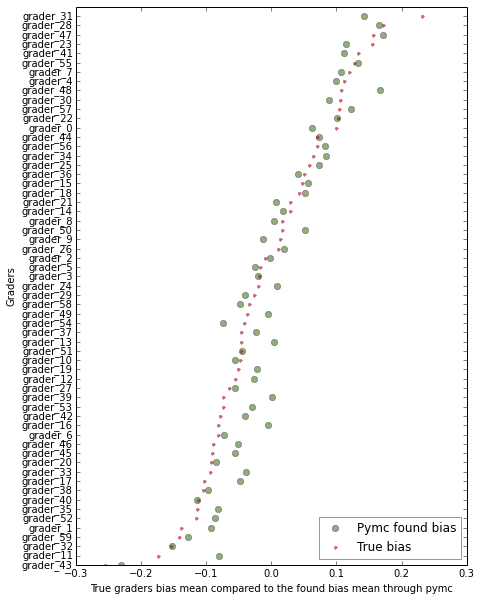

ValueError: max() arg is an empty sequence

In [315]:
compare_to_generated(assignment_data_true,[mcmc_peergrade]*3,find_bias,'mean')

## Oles

In [226]:
compare_to_generated(assignment_data_true,[mcmc_ole[0]]*3,find_bias,'mean')

TypeError: 'MCMC' object does not support indexing

### Model Comparison over 5 different data set

The model have been used on 5 different generated data set and then compared against eachother to see if one model is better than the others

In [ ]:
mesured_error = [[(4,0.001756),(1,0.001816),(2,0.001840),(3,0.002005),(6,0.002081),(5,0.002301)],
                 [(2,0.002043),(6,0.002046),(4,0.002279),(1,0.002351),(5,0.002987),(3,0.003079)],
                 [(6,0.001045),(3,0.001053),(4,0.001083),(1,0.001239),(2,0.001284),(5,0.003088)],
                 [(2,0.000934),(3,0.000990),(1,0.001000),(4,0.001183),(6,0.001282),(5,0.002000)],
                 [(4,0.001913),(1,0.002172),(2,0.002586),(3,0.002744),(6,0.003017),(5,0.003726)],
                 [(2,0.001213),(6,0.001242),(4,0.001312),(3,0.001362),(1,0.001644),(5,0.002533)],
                 [(1,0.000791),(6,0.000813),(3,0.000890),(4,0.000918),(2,0.000956),(5,0.001501)]]

In [ ]:

ax = plt.subplot(111)
colors = ['r','b','g','m','c','y']
lines = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (model,error) in data:
        lines[model].append((set_,error))
    
for model, l in lines.iteritems():
    xs = list()
    ys = list()
    for i in xrange(len(lines)+1):
        (x1,y1) = l[i]
        xs.append(x1+1)
        ys.append(y1)
    
    line = plt.plot(xs,ys,colors[model-1],label="model %i" % model)


box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*2, box.height*1.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("dataset")
plt.ylabel("Mean Square Error")
plt.show()

In [ ]:
pos_m = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (pos, (model,error)) in enumerate(data):
        pos_m[model].append(pos)
        
for m, pos in pos_m.iteritems():
#    print m, pos
    print "model_" + str(m) + ": mean: " + str(np.mean(pos)) + ", median: " + str(np.median(pos))